In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset/hourly_radiation_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    52584 non-null  object 
 1   P       52584 non-null  float64
 2   Gb(i)   52584 non-null  float64
 3   Gd(i)   52584 non-null  float64
 4   Gr(i)   52584 non-null  float64
 5   H_sun   52584 non-null  float64
 6   T2m     52584 non-null  float64
 7   WS10m   52584 non-null  float64
 8   Int     52584 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [3]:
# Remove the 'Int' column and move 'P' to the end of the DataFrame
df = df.drop(columns='Int')
p_col = df.pop('P')
df['P'] = p_col

In [4]:
df.head(5)

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,P
0,20180101:0010,0.0,0.0,0.0,0.0,8.65,2.41,0.0
1,20180101:0110,0.0,0.0,0.0,0.0,8.64,2.48,0.0
2,20180101:0210,0.0,0.0,0.0,0.0,9.20,2.83,0.0
3,20180101:0310,0.0,0.0,0.0,0.0,9.58,3.10,0.0
4,20180101:0410,0.0,0.0,0.0,0.0,9.80,2.90,0.0


In [5]:
# Create a temporary DataFrame with datetime column
df_tmp = pd.DataFrame()
df_tmp['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

# Extract the year
df_tmp['year'] = df_tmp['time'].dt.year

# Count the number of measurements per year
count_per_year = df_tmp['year'].value_counts().sort_index()

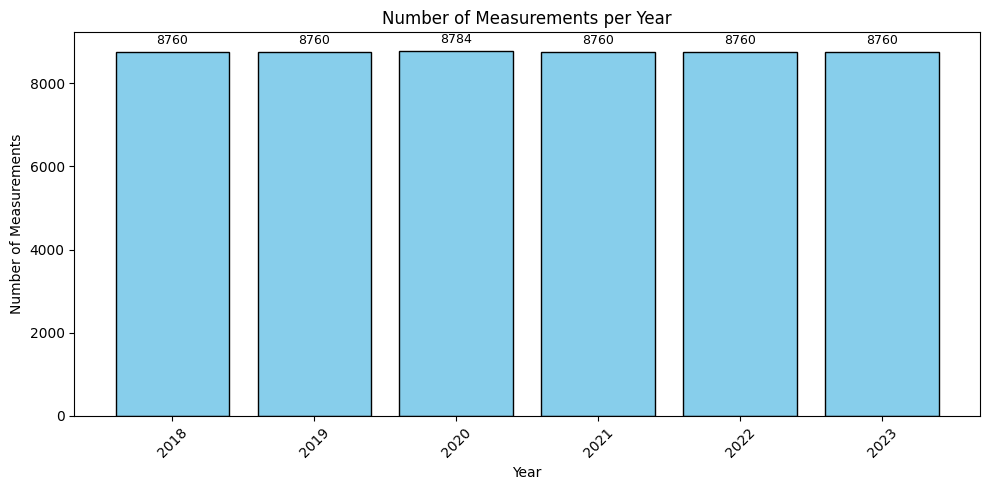

In [6]:
# Plot: Number of measurements per year
plt.figure(figsize=(10, 5))
bars = plt.bar(count_per_year.index.astype(str), count_per_year.values, color='skyblue', edgecolor='black')

# Add labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, str(int(height)), 
             ha='center', va='bottom', fontsize=9)

plt.title("Number of Measurements per Year")
plt.xlabel("Year")
plt.ylabel("Number of Measurements")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Filter data for a single day
mask_day = (df_tmp['time'].dt.date == pd.to_datetime("2023-07-10").date())
df_day = df.loc[mask_day].copy()
df_day['time'] = pd.to_datetime(df_day['time'], format='%Y%m%d:%H%M')

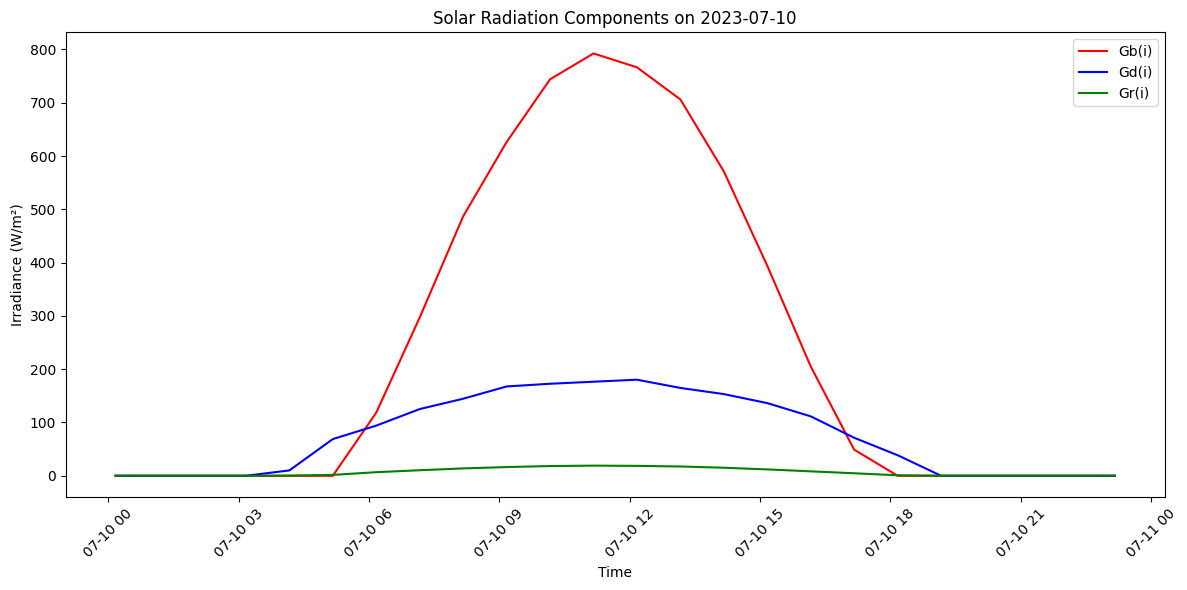

In [8]:
# Plot 1: Gb(i), Gd(i), Gr(i)

plt.figure(figsize=(12, 6))
plt.plot(df_day['time'], df_day['Gb(i)'], label="Gb(i)", color='red')
plt.plot(df_day['time'], df_day['Gd(i)'], label="Gd(i)", color='blue')
plt.plot(df_day['time'], df_day['Gr(i)'], label="Gr(i)", color='green')

plt.title("Solar Radiation Components on 2023-07-10")
plt.xlabel("Time")
plt.ylabel("Irradiance (W/m²)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

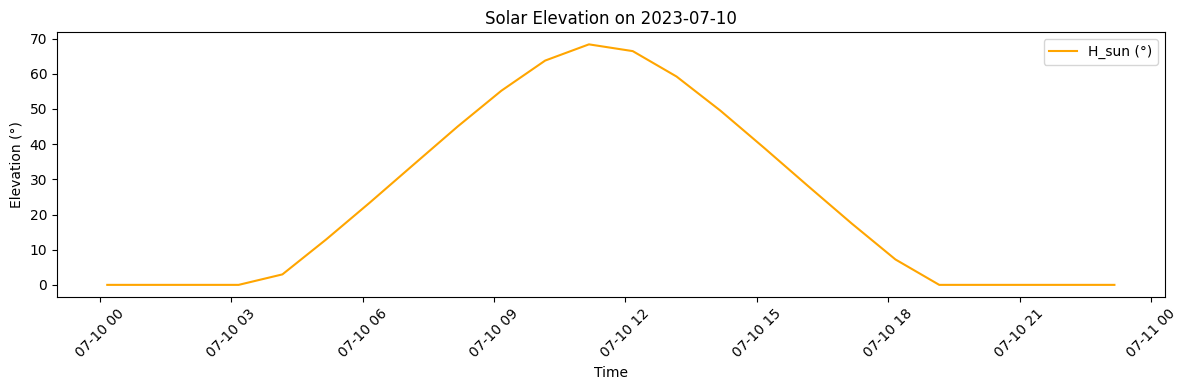

In [9]:
# Plot 2: H_sun

plt.figure(figsize=(12, 4))
plt.plot(df_day['time'], df_day['H_sun'], label="H_sun (°)", color='orange')

plt.title("Solar Elevation on 2023-07-10")
plt.xlabel("Time")
plt.ylabel("Elevation (°)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

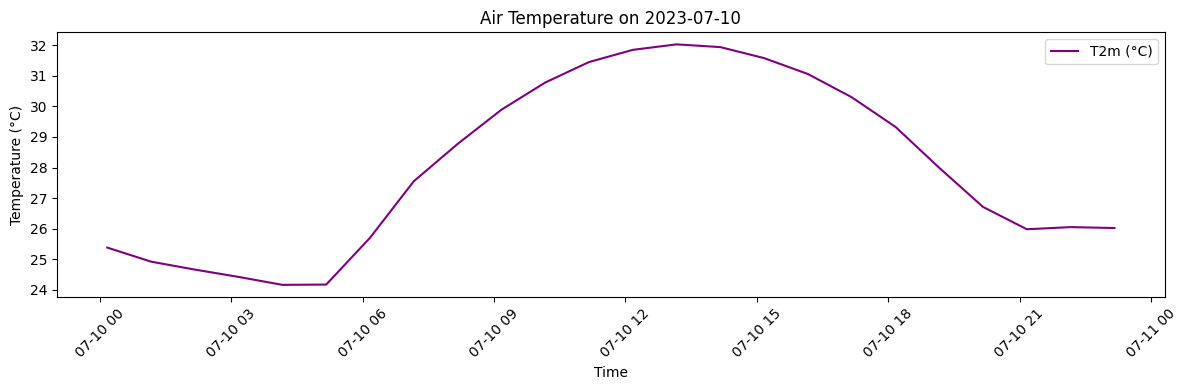

In [10]:
# Plot 3: T2m

plt.figure(figsize=(12, 4))
plt.plot(df_day['time'], df_day['T2m'], label="T2m (°C)", color='purple')

plt.title("Air Temperature on 2023-07-10")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

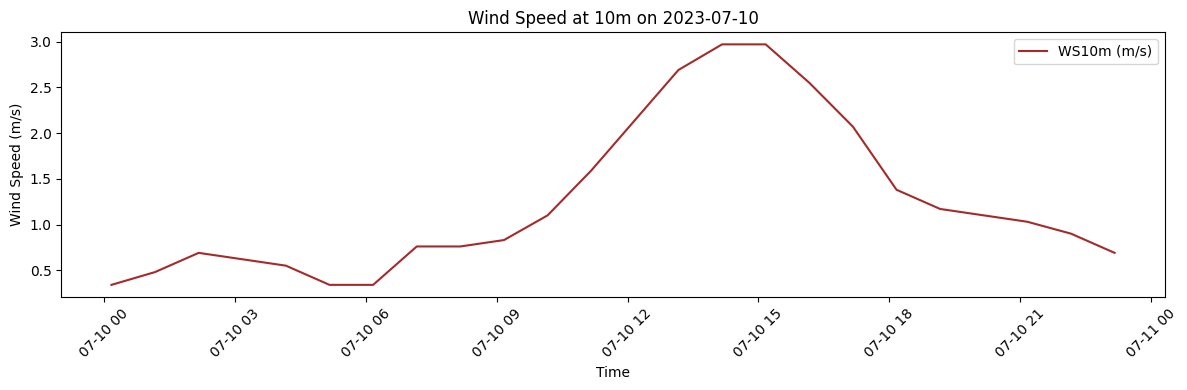

In [11]:
# Plot 3: WS10m

plt.figure(figsize=(12, 4))
plt.plot(df_day['time'], df_day['WS10m'], label="WS10m (m/s)", color='brown')

plt.title("Wind Speed at 10m on 2023-07-10")
plt.xlabel("Time")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

# Set 'time' as index and sort
df = df.set_index('time').sort_index()

In [13]:
# Create a new datetime index with 15-minute frequency
new_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15min')

# Reindex, missing timestamps are NaN
df_15min = df.reindex(new_idx)

# Pre-fill zeros in 'P' based on endpoint logic
for t in df.index[:-1]:
    t_next = t + pd.Timedelta(hours=1)
    if t_next not in df.index:
        continue
    
    p_start = df.loc[t, 'P']
    p_end = df.loc[t_next, 'P']
    
    interval_15 = pd.date_range(start=t, end=t_next, freq='15min')
    
    if p_start == 0 and p_end != 0:
        df_15min.loc[interval_15[:3], 'P'] = 0
    elif p_start != 0 and p_end == 0:
        df_15min.loc[interval_15[-3:], 'P'] = 0
    elif p_start == 0 and p_end == 0:
        df_15min.loc[interval_15, 'P'] = 0

# Interpolate all columns linearly
df_15min = df_15min.interpolate(method="linear", limit_direction="both")

# Reset index and round values
df_15min = df_15min.reset_index().rename(columns={'index': 'time'})
df_15min[['Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'P']] = df_15min[['Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'P']].round(0).astype(int)

df_15min.to_csv("dataset/radiation_data_15min.csv", index=False, float_format="%.4f")

df_15min.head(5)

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,P
0,2018-01-01 00:10:00,0,0,0,0,9,2,0
1,2018-01-01 00:25:00,0,0,0,0,9,2,0
2,2018-01-01 00:40:00,0,0,0,0,9,2,0
3,2018-01-01 00:55:00,0,0,0,0,9,2,0
4,2018-01-01 01:10:00,0,0,0,0,9,2,0


In [14]:
# Filter only data from May 2023
df_15min_filtered = df_15min[(df_15min['time'].dt.year == 2023) & (df_15min['time'].dt.month == 5)].copy()

# Set 'time' as datetime index
df_15min_filtered = df_15min_filtered.set_index('time')

# Create a new datetime index with 20-second frequency
new_idx_20s = pd.date_range(start=df_15min_filtered.index.min(), end=df_15min_filtered.index.max(), freq='20s')

# Reindex to create empty rows for interpolation
df_20s = df_15min_filtered.reindex(new_idx_20s)

# Pre-fill zeros in 'P' based on endpoint logic
for t in df_15min_filtered.index[:-1]:
    t_next = t + pd.Timedelta(minutes=15)
    if t_next not in df_15min_filtered.index:
        continue
    
    p_start = df_15min_filtered.loc[t, 'P']
    p_end = df_15min_filtered.loc[t_next, 'P']
    
    interval_20sec = pd.date_range(start=t, end=t_next, freq='20s')
    
    if p_start == 0 and p_end != 0:
        df_20s.loc[interval_20sec[:30], 'P'] = 0
    elif p_start != 0 and p_end == 0:
        df_20s.loc[interval_20sec[-30:], 'P'] = 0
    elif p_start == 0 and p_end == 0:
        df_20s.loc[interval_20sec, 'P'] = 0

# Apply linear interpolation on all columns
df_20s = df_20s.interpolate(method='linear', limit_direction='both')

# Reset index and round numerical values
df_20s = df_20s.reset_index().rename(columns={'index': 'time'})
df_20s[['Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'P']] = df_20s[['Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'P']].round(0).astype(int)

df_20s.to_csv("dataset/radiation_data_20sec.csv", index=False, float_format="%.4f")

df_20s.head(5)

,time,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,P
0,2023-05-01 00:10:00,0,0,0,0,15,2,0
1,2023-05-01 00:10:20,0,0,0,0,15,2,0
2,2023-05-01 00:10:40,0,0,0,0,15,2,0
3,2023-05-01 00:11:00,0,0,0,0,15,2,0
4,2023-05-01 00:11:20,0,0,0,0,15,2,0


In [15]:
# Set 'time' as datetime index
df_20s = df_20s.set_index('time')

# Create a new datetime index with 5-second frequency
new_idx_5s = pd.date_range(start=df_20s.index.min(), end=df_20s.index.max(), freq='5s')

# Reindex to create empty rows for interpolation
df_5s = df_20s.reindex(new_idx_5s)

# Keep only 'time' and 'P' columns
df_5s = df_5s[['P']]

# Pre-fill zeros in 'P' based on endpoint logic
for t in df_20s.index[:-1]:
    t_next = t + pd.Timedelta(seconds=20)
    if t_next not in df_20s.index:
        continue
    
    p_start = df_20s.loc[t, 'P']
    p_end = df_20s.loc[t_next, 'P']
    
    interval_5sec = pd.date_range(start=t, end=t_next, freq='5s')
    
    if p_start == 0 and p_end != 0:
        df_5s.loc[interval_5sec[:4], 'P'] = 0
    elif p_start != 0 and p_end == 0:
        df_5s.loc[interval_5sec[-4:], 'P'] = 0
    elif p_start == 0 and p_end == 0:
        df_5s.loc[interval_5sec, 'P'] = 0

# Apply linear interpolation on all columns
df_5s = df_5s.interpolate(method='linear', limit_direction='both')

# Reset index and round numerical values
df_5s = df_5s.reset_index().rename(columns={'index': 'time'})
df_5s[['P']] = df_5s[['P']].round(0).astype(int)

df_5s.to_csv("dataset/real_power_data_5sec.csv", index=False, float_format="%.4f")

df_5s.head(5)

,time,P
0,2023-05-01 00:10:00,0
1,2023-05-01 00:10:05,0
2,2023-05-01 00:10:10,0
3,2023-05-01 00:10:15,0
4,2023-05-01 00:10:20,0
